In [3]:
%%HTML
<h1>
    Author: Zackary Bair<br>
    Project: Sodium Iodide<br>
    File: zackaryBairRadioactiveVersionOne.ipynb<br>
</h1>
<h2>
    <br>
    <br>
    Better working software for the Hantek PC Oscilloscope/Function Gernerator.<br>
    Some of the code was given by a fellow student.<br>
    Done as research under Professor To at California State University Stanislaus.
</h2>


In [4]:
%%HTML
<h3>
    Below is a todo list of things that will still need to be done
</h3>

In [5]:
%%HTML
<h3>
    These are the todos for the project:
        revamp control condition (go in)
            will need to implement a better time run method that will get as close to the time in minutes run as possible
</h3>

In [6]:
%%HTML
<h3>
    Below are the global variables for the software.  Things to change how the program function are down below
</h3>


In [24]:
#PLOT
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#used for calling the read data from the scope
NUMBER_OF_SAMPLES_READ = 2000
#changes how many points are displayed in the plot
NUMBER_OF_SAMPLES_SAVED = 150 #half of the points on the plot

#changes the dimensions of the plot
PLOT_WIDTH = 15
PLOT_HEIGHT = 6
NUMBER_OF_ROWS = 1
NUMBER_OF_COLUMNS = 3
#NOTE: specifications for individual plots in the large plot are in the main function

#changes the lables on the plot's axises
PLOT_LABEL_X_AXIS = 'time[uS]'
PLOT_LABEL_Y_AXIS = 'Volt [V]'

#time of pause between plots updating (each multiple of 1 is a second)
PAUSE_TIME = 1


#TRIGGERS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#the triggers for the detectors
CHANNEL_ONE_TRIG = 0.01
CHANNEL_TWO_TRIG = 0.01

#veto means only channel one was triggered (could be a gamma ray)
#TRIGGER_TYPE = 'Veto'
#coincidence means both channel one and channel two was triggered (possibly a muon)
TRIGGER_TYPE = 'Coincidence'
#negative means that no channel was triggered (no interactions)
#TRIGGER_TYPE = 'Negative'

#number of data points for the coincidence window
COINCIDENCE_WINDOW = 50


#FORMATTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#header formatting
HEADER = ['Time', 'Channel One', 'Channel Two']

USER_NAME = 'bairz'
#common users
#bairz - Zackary's desktop
#Zackary Bair - Zackary's laptop

#directory for the csv data file
#most common directory will be in the "C:" drive (what the os will be on)
USER_DIRECTORY = 'C:\\Users\\' + USER_NAME
DIRECTORY_OUT = USER_DIRECTORY + '\\Documents\\RISE\\2020\\Spring\\NaI\\PythonFiles\\Data\\'
FILE_EXTENSION = '.csv'


#CONTROL LOOP
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#with a one second pause, time ran = varseconds * (range)
#var is dependent on processing power and can be between 27-32 based on tests
#the var is based on processing power
#time to run scales linearly
RUN_TIME_IN_MINUTES = 1


#creates the plots in the notebook rather than in a seperate window
#doesn't always seem to be necessary?
%matplotlib inline


#IMPORTS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import os
import sys
import time
import csv

import matplotlib.pyplot as plt
import numpy as np

from HTSDKScope import Oscilloscope
from IPython.display import clear_output


In [8]:
%%html
<h3>
    Below is the functions for the application as well as the only class that is used.<br>
    This does not include the main.
</h3>


In [9]:
#CLASSES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

class NullWriter(object):
    def write(self, arg):
        """
            Disables the oscilloscope
        """
        pass
    

#FUNCTIONS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def SetScope(channelOneVDivIndex = 0, channelTwoVDivIndex = 0, timeDivIndex = 11): 
    """
        Sets up the scope
        Takes in an integer channelOneDivIndex
        Takes in an integer channelTwoDivIndex
        Takes in an integer timeDivIndex
        Returns a touple that contains the ___, time scale, voltage scale one, and voltage scale two
    """

    voltageScaleTwo = voltageScaleOne = timeScale = 1
    
    """
        0: ('20 mV / Div', 0.02), 
        1: ('50 mV / Div', 0.05), 
        2: ('100 mV / Div', 0.1), 
        3: ('200 mV / Div', 0.2), 
        4: ('500 mV / Div', 0.5), 
        5: ('1 V / Div', 1.0), 
        6: ('2 V / Div', 2.0), 
        7: ('5 V / Div', 5.0)        
    """
    
    if (channelOneVDivIndex == 0): 
        voltageScaleOne = 0.02 / 32
    elif (channelOneVDivIndex == 1): 
        voltageScaleOne = 0.05 / 32
    elif (channelOneVDivIndex == 2): 
        voltageScaleOne = 0.1 / 32
    elif (channelOneVDivIndex == 3): 
        voltageScaleOne = 0.2 / 32
    elif (channelOneVDivIndex == 4): 
        voltageScaleOne = 0.5 / 32
    elif (channelOneVDivIndex == 5): 
        voltageScaleOne = 1.0 / 32
    elif (channelOneVDivIndex == 6): 
        voltageScaleOne = 2.0 / 32
    else: voltageScaleOne = 5.0 / 32 
        
    if(channelOneVDivIndex == 0): 
        voltageScaleTwo = 0.02 / 32 
    elif(channelOneVDivIndex == 1): 
        voltageScaleTwo = 0.05 / 32
    elif(channelOneVDivIndex == 2): 
        voltageScaleTwo = 0.1 / 32
    elif(channelOneVDivIndex == 3): 
        voltageScaleTwo = 0.2 / 32
    elif(channelOneVDivIndex == 4): 
        voltageScaleTwo = 0.5 / 32
    elif(channelOneVDivIndex == 5): 
        voltageScaleTwo = 1.0 / 32
    elif(channelOneVDivIndex == 6): 
        voltageScaleTwo = 2.0 / 32
    else: voltageScaleTwo = 5.0 / 32
                
    # timeDivIndex 
    """
        0: ('48 MSa / s', 48000000.0), 
        1: ('48 MSa / s', 48000000.0), 
        2: ('48 MSa / s', 48000000.0), 
        3: ('48 MSa / s', 48000000.0),
        4: ('48 MSa / s', 48000000.0), 
        5: ('48 MSa / s', 48000000.0), 
        6: ('48 MSa / s', 48000000.0), 
        7: ('48 MSa / s', 48000000.0), 
        8: ('48 MSa / s', 48000000.0), 
        9: ('48 MSa / s', 48000000.0), 
        10: ('48 MSa / s', 48000000.0), 
        11: ('16 MSa / s', 16000000.0), 
        12: ('8 MSa / s', 8000000.0), 
        13: ('4 MSa / s', 4000000.0), 
        14: ('1 MSa / s', 1000000.0), 
        15: ('1 MSa / s', 1000000.0), 
        16: ('1 MSa / s', 1000000.0), 
        17: ('1 MSa / s', 1000000.0), 
        18: ('1 MSa / s', 1000000.0), 
        19: ('1 MSa / s', 1000000.0), 
        20: ('1 MSa / s', 1000000.0), 
        21: ('1 MSa / s', 1000000.0), 
        22: ('1 MSa / s', 1000000.0), 
        23: ('1 MSa / s', 1000000.0), 
        24: ('1 MSa / s', 1000000.0), 
        25: ('500 KSa / s', 500000.0), 
        26: ('200 KSa / s', 200000.0), 
        27: ('100 KSa / s', 100000.0)
    """

    if(channelOneVDivIndex == 0): 
        timeScale = 2e4
    elif(channelOneVDivIndex == 1): 
        timeScale = 2e4 * 3.
    else: 
        timeScale = 2e4 * 3.

    scopeZero = Oscilloscope(scopeid = 0)
    scopeZero.set_voltage_division(1, channelOneVDivIndex)
    scopeZero.set_voltage_division(2, channelTwoVDivIndex)
    scopeZero.set_sampling_rate(timeDivIndex)

    nullwrite = NullWriter()
    oldstdout = sys.stdout
    sys.stdout = nullwrite # disable output
    scopeZero.setup_dso_cal_level() 
    sys.stdout = oldstdout # enable output 
    return scopeZero, timeScale, voltageScaleOne, voltageScaleTwo

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def saveData(data, start, end, outFile):
    #create the writer
    writer = csv.writer(outFile)
    
    
    try:
        #writes all of the samples within the range given
        #header
        writer.writerow(data[0])
        #print(data[0])

        #the event data (for the negative trigger that is all data)
        writer.writerows(data[start : end])
    except Exception as error:
        print('ERROR: failure to save data.')
        print(error)
        
    return


In [10]:
%%HTML
<h1>
    Below is the main fuction for the program.
</h1>

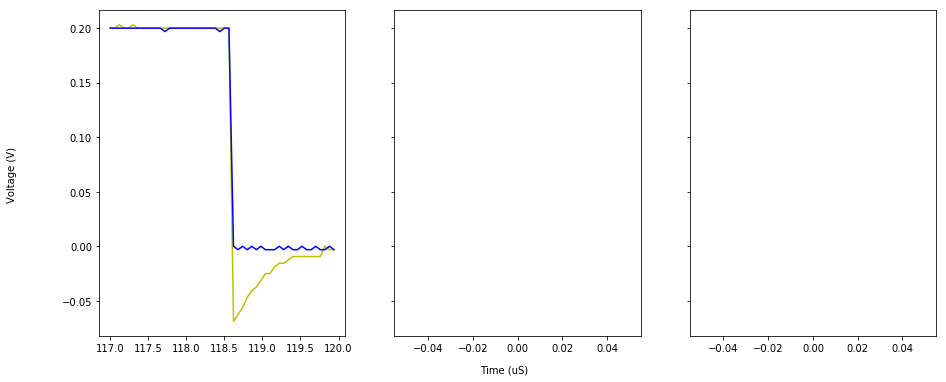

SET RUN COMPLETE.
TERMINATING PROGRAM.


In [25]:
#MAIN
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#start

#setup plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#setting up how the plot displays
plt.rcParams['figure.figsize'] = [PLOT_WIDTH, PLOT_HEIGHT] #[width, height]
plt.xlabel(PLOT_LABEL_X_AXIS)
plt.ylabel(PLOT_LABEL_Y_AXIS)


#setup scope
scopeZero = Oscilloscope(scopeid = 0)
scopeZero, timeScale, voltageScaleOne, voltageScaleTwo = SetScope(2,2,27)


#create data file
currentTime = time.localtime()
fileName = DIRECTORY_OUT
fileName += str(currentTime[0]) + '_' #year
fileName += str(currentTime[1]) + '_' #month
fileName += str(currentTime[2]) + '_' #day
fileName += str(currentTime[3]) #hour
fileName += str(currentTime[4]) #minute
fileName += FILE_EXTENSION

outFile = open(fileName, 'wb')
writer = csv.writer(outFile)
top = ['Trigger type:', TRIGGER_TYPE]
writer.writerow(top)


#has it been the full runtime? ~~~~~~~~~~~~~~~~~
#control loop
for i in range(RUN_TIME_IN_MINUTES * 2):
    #takes in data points
    rawData = scopeZero.read_data_from_scope(data_points = NUMBER_OF_SAMPLES_READ)

    #catching error if no signal is coming in
    try:
        #take in data from scope
        channelOneData = np.asarray(rawData[0]) * voltageScaleOne
        channelTwoData = np.asarray(rawData[1]) * voltageScaleTwo
        timeData = np.asarray(rawData[2]) * timeScale# conversion to microsec
    #was there data to take? ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #if error is detected, terminate program
    except:
        print('ERROR: No signal is detected.')
        print('Program terminated.')
        break
        
        
    #create data
    #stores all data in array
    data = []
    data.append(HEADER)
    #add in all taken data
    for i in range(timeData.size):
        row = []
        row.append(timeData[i])
        row.append(channelOneData[i])
        row.append(channelTwoData[i])
        data.append(row)
        
        
    #plot data
    pointsPlotted = 0
    #goes through each read point
    while (pointsPlotted <= NUMBER_OF_SAMPLES_READ):
        #he dimensions for the plot
        fig, axs = plt.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, sharex = False, sharey = True)
        fig.text(0.5, 0.04, 'Time (uS)', ha = 'center')
        fig.text(0.04, 0.5, 'Voltage (V)', va = 'center', rotation = 'vertical')
        #clear output only if you want to only see the current graphs
        #to keep all graphs comment out the below line
        clear_output(wait = True)
            
            
        #filling all subplots
        for i in range(NUMBER_OF_ROWS):
            for j in range(NUMBER_OF_COLUMNS):
                axs[i * NUMBER_OF_COLUMNS + j].plot(timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                    channelOneData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                    'y-',
                                                    timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                    channelTwoData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                    'b-')
                
            plt.show()
                
        #the pause between updates
        plt.pause(PAUSE_TIME)
        pointsPlotted += NUMBER_OF_SAMPLES_SAVED
        
        
        #what trigger type?
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        #negative
        if (TRIGGER_TYPE == 'Negative'):
            #has any channel been triggered?
            #if no channel was triggered
            if (channelOneData.max() < CHANNEL_ONE_TRIG and channelTwoData.max() < CHANNEL_TWO_TRIG):
                #save all data
                saveData(data, 1, len(data), outFile)
#                 try:
#                     #writes all of the samples within the range given
#                     #header
#                     writer.writerow(data[0])
#                     #print(data[0])

#                     #the event data (for the negative trigger that is all data)
#                     writer.writerows(data[1 : len(data)])
#                 except Exception as error:
#                     print('ERROR: failure to save data.')
#                     print(error)
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        #veto
        elif (TRIGGER_TYPE == 'Veto'):
            #has channel one been triggered?
            #if it was triggered
            if (channelOneData.max() > CHANNEL_ONE_TRIG):
                #was channel two triggered?
                #if it was not triggered
                if (channelTwoData.max() < CHANNEL_TWO_TRIG):
                    #setting the max
                    channelOneMax = np.argmax(channelOneData)
                    if (channelOneMax + NUMBER_OF_SAMPLES_SAVED > NUMBER_OF_SAMPLES_READ):
                        channelOneMax = NUMBER_OF_SAMPLES_READ - NUMBER_OF_SAMPLES_SAVED
                    if (channelOneMax - NUMBER_OF_SAMPLES_SAVED < 0):
                        channelOneMax = NUMBER_OF_SAMPLES_SAVED
                        
                    #saves event data
                    saveData(data, channelOneMax - NUMBER_OF_SAMPLES_SAVED + 1, channelOneMax + NUMBER_OF_SAMPLES_SAVED + 1, outFile)
                    #channelOneMax - NUMBER_OF_SAMPLES_SAVED + 1 : channelOneMax + NUMBER_OF_SAMPLES_SAVED + 1
                    pass
                
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        #coincidence
        elif (TRIGGER_TYPE == 'Coincidence'):
            #was channel one triggered?
            #if it was triggered
            if (channelOneData.max() > CHANNEL_ONE_TRIG):
                #save the max
                channelOneMax = np.argmax(channelOneData)
                if (channelOneMax + NUMBER_OF_SAMPLES_SAVED > NUMBER_OF_SAMPLES_READ):
                    channelOneMax = NUMBER_OF_SAMPLES_READ - NUMBER_OF_SAMPLES_SAVED
                if (channelOneMax - NUMBER_OF_SAMPLES_SAVED < 0):
                    channelOneMax = NUMBER_OF_SAMPLES_SAVED
                    
                    
                #checks for a trigger within the window
                for i in range(COINCIDENCE_WINDOW):
                    #was channel two triggered within the window
                    if (channelTwoData[i + channelOneMax] > CHANNEL_TWO_TRIG):
                        #event found
                        saveData(data, channelOneMax - NUMBER_OF_SAMPLES_SAVED + 1, channelOneMax + NUMBER_OF_SAMPLES_SAVED + 1, outFile)
                        break
        

#closing data file
#NOTE always close file to avoid issues with it
outFile.close()
    

#end
print('SET RUN COMPLETE.')
print('TERMINATING PROGRAM.')


In [ ]:
%%HTML
<h3>
    Below is some stuff that will be deleted later.
</h3>

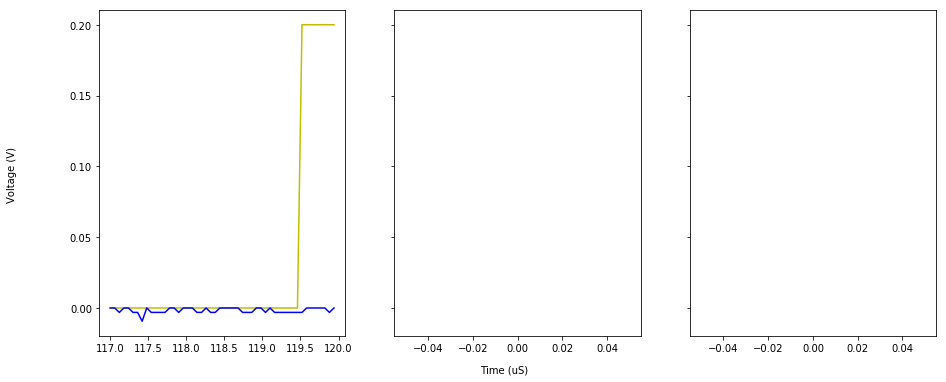

SET RUN COMPLETE.
TERMINATING PROGRAM.


In [51]:
#creates the plots in the notebook rather than in a seperate window
#doesn't always seem to be necessary?
%matplotlib inline


#IMPORTS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import os
import sys
import time
import csv

import matplotlib.pyplot as plt
import numpy as np

from HTSDKScope import Oscilloscope
from IPython.display import clear_output


#CLASSES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

class NullWriter(object):
    def write(self, arg):
        """
            Disables the oscilloscope
        """
        pass
    

#FUNCTIONS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def SetScope(channelOneVDivIndex = 0, channelTwoVDivIndex = 0, timeDivIndex = 11): 
    """
        Sets up the scope
        Takes in an integer channelOneDivIndex
        Takes in an integer channelTwoDivIndex
        Takes in an integer timeDivIndex
        Returns a touple that contains the ___, time scale, voltage scale one, and voltage scale two
    """

    voltageScaleTwo = voltageScaleOne = timeScale = 1
    
    """
        0: ('20 mV / Div', 0.02), 
        1: ('50 mV / Div', 0.05), 
        2: ('100 mV / Div', 0.1), 
        3: ('200 mV / Div', 0.2), 
        4: ('500 mV / Div', 0.5), 
        5: ('1 V / Div', 1.0), 
        6: ('2 V / Div', 2.0), 
        7: ('5 V / Div', 5.0)        
    """
    
    if (channelOneVDivIndex == 0): 
        voltageScaleOne = 0.02 / 32
    elif (channelOneVDivIndex == 1): 
        voltageScaleOne = 0.05 / 32
    elif (channelOneVDivIndex == 2): 
        voltageScaleOne = 0.1 / 32
    elif (channelOneVDivIndex == 3): 
        voltageScaleOne = 0.2 / 32
    elif (channelOneVDivIndex == 4): 
        voltageScaleOne = 0.5 / 32
    elif (channelOneVDivIndex == 5): 
        voltageScaleOne = 1.0 / 32
    elif (channelOneVDivIndex == 6): 
        voltageScaleOne = 2.0 / 32
    else: voltageScaleOne = 5.0 / 32 
        
    if(channelOneVDivIndex == 0): 
        voltageScaleTwo = 0.02 / 32 
    elif(channelOneVDivIndex == 1): 
        voltageScaleTwo = 0.05 / 32
    elif(channelOneVDivIndex == 2): 
        voltageScaleTwo = 0.1 / 32
    elif(channelOneVDivIndex == 3): 
        voltageScaleTwo = 0.2 / 32
    elif(channelOneVDivIndex == 4): 
        voltageScaleTwo = 0.5 / 32
    elif(channelOneVDivIndex == 5): 
        voltageScaleTwo = 1.0 / 32
    elif(channelOneVDivIndex == 6): 
        voltageScaleTwo = 2.0 / 32
    else: voltageScaleTwo = 5.0 / 32
                
    # timeDivIndex 
    """
        0: ('48 MSa / s', 48000000.0), 
        1: ('48 MSa / s', 48000000.0), 
        2: ('48 MSa / s', 48000000.0), 
        3: ('48 MSa / s', 48000000.0),
        4: ('48 MSa / s', 48000000.0), 
        5: ('48 MSa / s', 48000000.0), 
        6: ('48 MSa / s', 48000000.0), 
        7: ('48 MSa / s', 48000000.0), 
        8: ('48 MSa / s', 48000000.0), 
        9: ('48 MSa / s', 48000000.0), 
        10: ('48 MSa / s', 48000000.0), 
        11: ('16 MSa / s', 16000000.0), 
        12: ('8 MSa / s', 8000000.0), 
        13: ('4 MSa / s', 4000000.0), 
        14: ('1 MSa / s', 1000000.0), 
        15: ('1 MSa / s', 1000000.0), 
        16: ('1 MSa / s', 1000000.0), 
        17: ('1 MSa / s', 1000000.0), 
        18: ('1 MSa / s', 1000000.0), 
        19: ('1 MSa / s', 1000000.0), 
        20: ('1 MSa / s', 1000000.0), 
        21: ('1 MSa / s', 1000000.0), 
        22: ('1 MSa / s', 1000000.0), 
        23: ('1 MSa / s', 1000000.0), 
        24: ('1 MSa / s', 1000000.0), 
        25: ('500 KSa / s', 500000.0), 
        26: ('200 KSa / s', 200000.0), 
        27: ('100 KSa / s', 100000.0)
    """

    if(channelOneVDivIndex == 0): 
        timeScale = 2e4
    elif(channelOneVDivIndex == 1): 
        timeScale = 2e4 * 3.
    else: 
        timeScale = 2e4 * 3.

    scopeZero = Oscilloscope(scopeid = 0)
    scopeZero.set_voltage_division(1, channelOneVDivIndex)
    scopeZero.set_voltage_division(2, channelTwoVDivIndex)
    scopeZero.set_sampling_rate(timeDivIndex)

    nullwrite = NullWriter()
    oldstdout = sys.stdout
    sys.stdout = nullwrite # disable output
    scopeZero.setup_dso_cal_level() 
    sys.stdout = oldstdout # enable output 
    return scopeZero, timeScale, voltageScaleOne, voltageScaleTwo


#MAIN
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#setting up how the plot displays
plt.rcParams['figure.figsize'] = [PLOT_WIDTH, PLOT_HEIGHT] #[width, height]
plt.xlabel(PLOT_LABEL_X_AXIS)
plt.ylabel(PLOT_LABEL_Y_AXIS)


#scope
scopeZero = Oscilloscope(scopeid = 0)
scopeZero, timeScale, voltageScaleOne, voltageScaleTwo = SetScope(2,2,27)

#file
currentTime = time.localtime()
fileName = DIRECTORY_OUT
fileName += str(currentTime[0]) + '_' #year
fileName += str(currentTime[1]) + '_' #month
fileName += str(currentTime[2]) + '_' #day
fileName += str(currentTime[3]) #hour
fileName += str(currentTime[4]) #minute
fileName += FILE_EXTENSION

outFile = open(fileName, 'wb')
writer = csv.writer(outFile)
top = ['Trigger type:', TRIGGER_TYPE]
writer.writerow(top)


#control loop
for i in range(RUN_TIME_IN_MINUTES * 2):
    #takes in data points
    rawData = scopeZero.read_data_from_scope(data_points = NUMBER_OF_SAMPLES_READ)

    #catching error if no signal is coming in
    try:
        channelOneData = np.asarray(rawData[0]) * voltageScaleOne
        channelTwoData = np.asarray(rawData[1]) * voltageScaleTwo
        timeData = np.asarray(rawData[2]) * timeScale# conversion to microsec
    #if error is detected, terminate program
    except:
        print('ERROR: No signal is detected.')
        print('Program terminated.')
        break
        
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #veto trigger (only channel one recives a trigger)
    if (channelOneData.max() > CHANNEL_ONE_TRIG and TRIGGER_TYPE == 'Veto'):
        channelOneMax = np.argmax(channelOneData)
        
        if (channelOneMax + NUMBER_OF_SAMPLES_SAVED > NUMBER_OF_SAMPLES_READ):
            channelOneMax = NUMBER_OF_SAMPLES_READ - NUMBER_OF_SAMPLES_SAVED
            
        if (channelOneMax - NUMBER_OF_SAMPLES_SAVED < 0):
            channelOneMax = NUMBER_OF_SAMPLES_SAVED
            
            
        #plots data
        pointsPlotted = 0
        #goes through each read point
        while (pointsPlotted <= NUMBER_OF_SAMPLES_READ):
            #he dimensions for the plot
            fig, axs = plt.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, sharex = False, sharey = True)
            fig.text(0.5, 0.04, 'Time (uS)', ha = 'center')
            fig.text(0.04, 0.5, 'Voltage (V)', va = 'center', rotation = 'vertical')
            #clear output only if you want to only see the current graphs
            #to keep all graphs comment out the below line
            clear_output(wait = True)
            
            
            #filling all subplots
            for i in range(NUMBER_OF_ROWS):
                for j in range(NUMBER_OF_COLUMNS):
                    axs[i * NUMBER_OF_COLUMNS + j].plot(timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        channelOneData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        'y-',
                                                        timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        channelTwoData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        'b-')
                
                plt.show()
                
            #the pause between updates
            plt.pause(PAUSE_TIME)
            pointsPlotted += NUMBER_OF_SAMPLES_SAVED
                    
                    
        #create data
        data = []
        data.append(HEADER)
        #add in all taken data
        for i in range(timeData.size):
            row = []
            row.append(timeData[i])
            row.append(channelOneData[i])
            row.append(channelTwoData[i])
            data.append(row)
                    
        #saves data
        try:
            #writes all of the samples within the range given
            #header
            writer.writerow(data[0])
            #print(data[0])
                
            #the event data
            writer.writerows(data[channelOneMax - NUMBER_OF_SAMPLES_SAVED + 1 : channelOneMax + NUMBER_OF_SAMPLES_SAVED + 1])
        except Exception as error:
            print('ERROR: failure to save data.')
            print(error)
                    
        channelOneMax = 0
        
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #coincidence trigger (channel one is triggered and channel two is triggered within the coincidence window)
    else if (TRIGGER_TYPE == 'Coincidence'):
        #plot all data
        pointsPlotted = 0
        while (pointsPlotted <= NUMBER_OF_SAMPLES_READ):
            #the dimensions for the plot
            fig, axs = plt.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, sharex = False, sharey = True)
            fig.text(0.5, 0.04, 'Time (us)', ha = 'center')
            fig.text(0.04, 0.5, 'Voltage (V)', va = 'center', rotation = 'vertical')
            #clear output is only if you want just the current graphs plotted
            clear_output(wait = True)


            #filling all subplots
            for i in range(NUMBER_OF_ROWS):
                for j in range(NUMBER_OF_COLUMNS):
                    axs[i * NUMBER_OF_COLUMNS + j].plot(timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        channelOneData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        'y-',
                                                        timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        channelTwoData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        'b-')

                plt.show()

            #the pause between updates
            plt.pause(PAUSE_TIME)
            pointsPlotted += NUMBER_OF_SAMPLES_SAVED


        #looking for event
        for i in range(timeData.size):
            if (channelOneData[i] > CHANNEL_ONE_TRIG):
                for j in range(COINCIDENCE_WINDOW):
                    if (channelTwoData[j] > CHANNEL_TWO_TRIG):
                        #event found
                        #create data
                        data = []
                        data.append(HEADER)
                        #add in all data
                        for k in range(timeData.size):
                            row = []
                            row.append(timeData[i])
                            row.append(channelOneData[i])
                            row.append(channelTwoData[i])
                            data.append(row)

                            #saves data
                            try:
                                #writes all of the samples within the given range
                                #header
                                writer.writerow(data[0])

                                #the event data
                                eventIndex = i + j
                                writer.writerows(data[eventIndex - NUMBER_OF_SAMPLES_SAVED + 1 : eventIndex + NUMBER_OF_SAMPLES_SAVED + 1])
                            except Exception as error:
                                print('ERROR: failure to save data.')
                                print(error)

                        #correct i counter
                        i = i + j + 1
                        #break out of j loop
                        break
                
                
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #negative trigger (no instances one both channel one and channel two)
    else if (channelOneData.max < CHANNEL_ONE_TRIG and channelTwoData.max < CHANNEL_TWO_TRIG and TRIGGER_TYPE == 'Negative'):
        #plot all data
        pointsPlotted = 0
        while (pointsPlotted <= NUMBER_OF_SAMPLES_READ):
            #the dimensions for the plot
            fig, axs = plt.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, sharex = False, sharey = True)
            fig.text(0.5, 0.04, 'Time (us)', ha = 'center')
            fig.text(0.04, 0.5, 'Voltage (V)', va = 'center', rotation = 'vertical')
            #clear output is only if you want just the current graphs plotted
            clear_output(wait = True)
            
            
            #filling all subplots
            for i in range(NUMBER_OF_ROWS):
                for j in range(NUMBER_OF_COLUMNS):
                    axs[i * NUMBER_OF_COLUMNS + j].plot(timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        channelOneData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        'y-',
                                                        timeData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        channelTwoData[pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * j): pointsPlotted + (NUMBER_OF_SAMPLES_SAVED * (j + 1))],
                                                        'b-')
                
                plt.show()
                
            #the pause between updates
            plt.pause(PAUSE_TIME)
            pointsPlotted += NUMBER_OF_SAMPLES_SAVED
        
        
        #create data
        data = []
        data.append(HEADER)
        for i in range(timeData.size):
            row = []
            row.append(timeData[i])
            row.append(channelOneData[i])
            row.append(channelTwoData[i])
            data.append(row)
        
        #save all data
        try:
            #writes all of the samples
            #header
            writer.writerow(data[0])
            
            #all of the data
            writter.writerows(data)
        except Exception as error:
            print('ERROR: failure to save data.')
            print(error)
        
    
#NOTE always close file to avoid issues with it
outFile.close()
    
            
print('SET RUN COMPLETE.')
print('TERMINATING PROGRAM.')
